In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta,date ,time

#### reading the files ,5min sentiment data and 1 min HF index data for period of jan-june 2022

In [ ]:
data = pd.read_csv('mean_sentiment_df_5min_from_january.csv')
fdata = pd.read_csv('FTSE100-1m.csv')
fdata.columns = ['Date','price']
sdata = data[['Date','Vader-Compound']]
sdata['Date'] = pd.to_datetime(sdata['Date'],utc=False)
sdata['Date'] = sdata['Date'].dt.tz_localize(None)
fdata['Date'] = pd.to_datetime(fdata['Date'],utc=False)
fdata = fdata.loc[fdata['Date']>='2022-01-01 00:00:00']
sdata = sdata.loc[sdata['Date']>='2022-01-01 00:00:00']
fdata = fdata.reset_index(drop=True)
sdata = sdata.reset_index(drop=True)

#### creating a function to calculate log returns and higher moments

In [3]:
def moments_daily_frequency(data_df):
    return_data_df = pd.DataFrame()
    # Iterate through each day by filter (group by index date)
    # dt.date finds the date out of the full DateTime object
    for index, day_df in data_df.groupby(data_df.Date.dt.date):
        #print('NEW DAY', len(day_df['Date']))
        day_df['log_return'] = np.log(day_df['price']).diff()
        
        # The Moving Rolling does not take care of Nan
        # Higher Moments based on Log-Return
        day_df['variance'] = day_df['log_return'].rolling(5).var()
        day_df['skewness'] = day_df['log_return'].rolling(5).skew()
        day_df['kurtosis'] = day_df['log_return'].rolling(5).kurt()
        
        # Add to a new Dataframe
        return_data_df = pd.concat([return_data_df, day_df], ignore_index=True, sort=False)

    return return_data_df

In [4]:
fdata_updated = moments_daily_frequency(fdata)
fdata_final = fdata_updated.dropna()
fdata_final = fdata_final.reset_index(drop=True)
fdata_final.shape,fdata_updated.shape

((55101, 6), (55646, 6))

In [5]:
len(fdata.groupby(fdata.Date.dt.date))

109

In [6]:
55646 -109*5

55101

In [7]:
fdata_final.head()

,Date,price,log_return,variance,skewness,kurtosis
0,2022-01-04 09:05:00,7464.29,0.000192,2.643492e-07,-2.188352,4.825807
1,2022-01-04 09:06:00,7462.64,-0.000221,2.613445e-07,-1.568983,1.983444
2,2022-01-04 09:07:00,7460.41,-0.000299,7.194393e-08,-0.619158,-3.003979
3,2022-01-04 09:08:00,7460.88,0.000063,6.161556e-08,-0.322841,-2.650714
4,2022-01-04 09:09:00,7457.17,-0.000497,7.747822e-08,0.121962,-1.585160


#### The log returns for the HF 1 min data for FTSE-100 is stationary

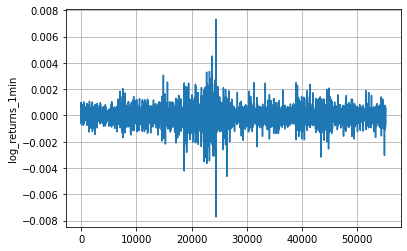

In [8]:
fdata_final['log_return'].plot()
plt.grid()
plt.ylabel('log_returns_1min')
plt.show()

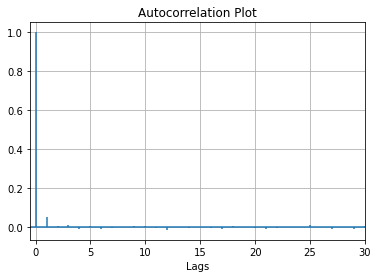

In [9]:
plt.acorr(fdata_final['log_return'], maxlags = 30)
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")
plt.xlim(-0.5,30)
plt.grid()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(fdata_final['log_return'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -28.638327
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


#####  AR model can be applied as the log returns are stationary ,(P-value < 0.005)

In [11]:
y = fdata_final['log_return'].shift(1)
X = fdata_final['log_return']
y.shape,X.shape

((55101,), (55101,))

In [41]:
data = fdata_final['log_return']

#### THE AR(1) model is created without including the twitter sentiments

In [42]:
#Scale the data
data_scaled = (data-data.min())/(data.max()-data.min())

#Add constant c
data_scaled = sm.add_constant(data_scaled)

#Split train and test sets
split = int(0.60 * data.shape[0])
X = data_scaled
y = data_scaled.shift(-1)['log_return']
X_train, X_test = X[:split], X[split:-1]
y_train, y_test = y[:split], y[split:-1]
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     41.57
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           1.15e-10
Time:                        00:31:32   Log-Likelihood:                 76406.
No. Observations:               33060   AIC:                        -1.528e+05
Df Residuals:                   33058   BIC:                        -1.528e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4950      0.003    175.295      0.000       0.489       0.501
log_return     0.0354      0.005      6.447      0.000       0.025       0.046
==============================================================================
Omnibus:                     8943.214   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           927004.189
Skew:                          -0.099   Prob(JB):                         0.00
Kurtosis:                      28.941   Cond. No.                         52.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

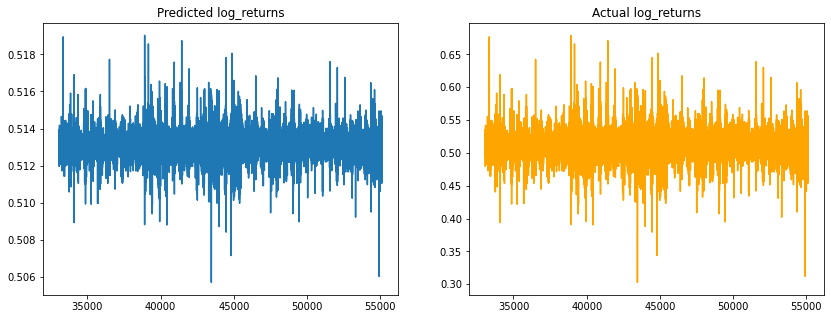

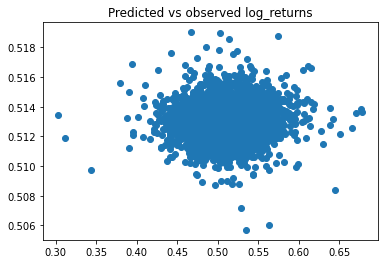

In [43]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted log_returns")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual log_returns")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed log_returns")
plt.show()

In [44]:
# Metrics
def score(y_hat, y, metric):
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0005755641072158104, R^2:0.0012558310639728676, MAE:0.015555225997237925
----------------
Out-of-sample scores
MSE:0.00033698205078865794, R^2:0.005141952060602195, MAE:0.012880831993639182


In [45]:
X.shape,y.shape

((55101, 2), (55101,))

##### HAR Model

In [46]:
def get_lag(data):
    lag_data = []
    for i in range(1,23):
        temp = data.shift(i)
        lag_data.append(temp)

    ldf = pd.DataFrame(lag_data)
    ldf = ldf.T
    ldf.columns = ["lag"+ str(i) for i in range(1,23)]
    ldf.reset_index(drop=True,inplace=True)
    ldf = ldf.iloc[22:,:]
    return ldf

data_scaled = (data-data.min())/(data.max()-data.min())
ldf = get_lag(data_scaled)
#print(ldf)
data_scaled = sm.add_constant(data_scaled)
X = data_scaled
X2 = ldf.iloc[:,:5].sum(axis=1)
X22 = ldf.iloc[:,:22].sum(axis=1)
X2 = X2[:len(X22)]
X = X[:len(X22)]
X = np.array(X)
X2 = np.array(X2)
X22 = np.array(X22)
X_tot = np.column_stack((X,X2,X22))
#X_tot = X_tot[:-1,:]
y = data_scaled.shift(-22)['log_return']
y = y.dropna()
print(X.shape,y.shape)
split = int(0.60 * X_tot.shape[0])
X_train, X_test = X_tot[:split], X_tot[split:]
y_train, y_test = y[:split], y[split:]
results = sm.OLS(y_train, X_train).fit()
results.summary()

(55079, 2) (55079,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.450
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           0.000962
Time:                        00:31:49   Log-Likelihood:                 76368.
No. Observations:               33047   AIC:                        -1.527e+05
Df Residuals:                   33043   BIC:                        -1.527e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5089      0.013     39.567      0.000       0.484       0.534
x1            -0.0021      0.006     -0.371      0.711      -0.013       0.009
x2             0.0108      0.003      3.939      0.000       0.005       0.016
x3            -0.0020      0.001     -1.478      0.139      -0.005       0.001
==============================================================================
Omnibus:                     8858.680   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           886920.997
Skew:                          -0.090   Prob(JB):                         0.00
Kurtosis:                      28.379   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

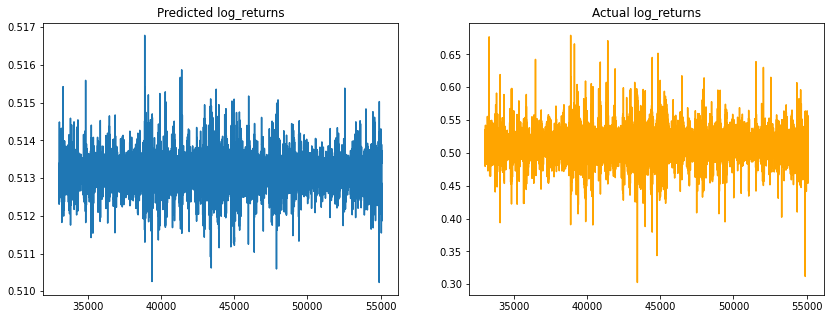

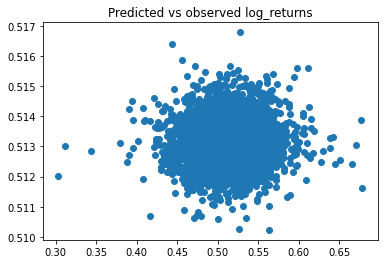

In [47]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted log_returns")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual log_returns")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed log_returns")
plt.show()

In [48]:
# Metrics
def score(y_hat, y, metric):
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0005758649325606216, R^2:0.0004946043505024145, MAE:0.015567985978606874
----------------
Out-of-sample scores
MSE:0.00033825043562608914, R^2:0.0016747788435770294, MAE:0.012905412129276256


#### Adding the twitter sentiment component to the HAR model

In [20]:
### cleaning the sentiment data for out of cstock time window 
### appennding the sentiment of after 3pm tweets to next data stock sentiment for each of the trading day from jan-june 2022

sdata_shifted = sdata.copy()
sdata_shifted['Date'] = sdata['Date'] + timedelta( hours=5 )
out_of_time = []
in_time_sdata = pd.DataFrame()
for index,day_df in sdata_shifted.groupby(sdata_shifted.Date.dt.date):
    l =[]
    temp1 = day_df.loc[(day_df['Date'].dt.time < time(9,00,00))]
    temp2 = day_df.loc[(day_df['Date'].dt.time > time(15,00,00))]
    m1 = temp1['Vader-Compound'].mean()
    m2 = temp2['Vader-Compound'].mean()
    out_of_time.append([m1,m2])
    temp_df = day_df.loc[(day_df['Date'].dt.time >= time(9,00,00)) & (day_df['Date'].dt.time <= time(15,00,00))]
    in_time_sdata = pd.concat([in_time_sdata,temp_df])
means = []
means.append(out_of_time[0][0])
for idx in range(len(out_of_time)):
    v1 = out_of_time[idx][0]
    v2 = out_of_time[idx-1][1]
    val = (v1+v2)/2.0
    means.append(val)  
l = [x for x in means if ~np.isnan(x)]
ct = 0
for index,day_df in in_time_sdata.groupby(in_time_sdata.Date.dt.date):
    day_df['Vader-Compound']+=l[ct]
    ct+=1

In [21]:
in_time_fdata = pd.DataFrame()
for index,day_df in fdata.groupby(fdata.Date.dt.date):
    temp_df = day_df.loc[(day_df['Date'].dt.time >= time(9,00,00)) & (day_df['Date'].dt.time <= time(15,00,00))]
    in_time_fdata = pd.concat([in_time_fdata,temp_df])
in_time_fdata_min5 = in_time_fdata.groupby(pd.Grouper(key = 'Date',freq='5min')).agg({"price":"last"})
in_time_fdata_min5 = in_time_fdata_min5.reset_index()

In [22]:
in_time_sdata = in_time_sdata.reset_index(drop=True)
in_time_fdata_min5 = in_time_fdata_min5.reset_index(drop=True)

In [28]:
combined_df = pd.merge(in_time_fdata_min5,in_time_sdata,on='Date')

In [29]:
final_df = moments_daily_frequency(combined_df)
final_df = final_df.dropna()
final_df = final_df.reset_index(drop=True)

C:\Users\rkroc\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:455: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


In [30]:
final_df

,Date,price,Vader-Compound,log_return,variance,skewness,kurtosis
0,2022-01-04 09:25:00,7465.89,0.29295,-0.000591,7.295352e-07,0.854009,0.236416
1,2022-01-04 09:30:00,7468.29,0.00000,0.000321,5.071441e-07,0.601678,1.561655
2,2022-01-04 09:35:00,7475.91,0.34540,0.001020,5.681105e-07,-0.470945,0.004838
3,2022-01-04 09:40:00,7480.16,0.00000,0.000568,3.452640e-07,-0.958749,2.067762
4,2022-01-04 09:45:00,7482.55,0.00000,0.000319,3.450295e-07,-0.881375,1.908226
...,...,...,...,...,...,...,...
7396,2022-06-10 14:40:00,7354.07,0.81760,0.000148,6.880372e-06,-1.553213,3.212238
7397,2022-06-10 14:45:00,7352.83,0.00000,-0.000169,6.965895e-06,-1.653777,3.460776
7398,2022-06-10 14:50:00,7352.13,0.00000,-0.000095,7.041021e-06,-1.730057,3.659552
7399,2022-06-10 14:55:00,7339.42,-0.20230,-0.001730,1.509707e-06,0.091685,1.823845


In [84]:
#Scale the data
data = final_df['log_return']
data_scaled = (data-data.min())/(data.max()-data.min())

#Add constant c
data_scaled = sm.add_constant(data_scaled)

#Split train and test sets
split = int(0.60 * data.shape[0])
X = data_scaled
X_tweet = final_df['Vader-Compound']
X_tot = np.column_stack((X,X_tweet))
y = data_scaled.shift(-1)['log_return']
y = y.dropna()
X_tot = X_tot[:len(y)]
print(X_tot.shape,y.shape)
split = int(0.60 * X_tot.shape[0])
X_train, X_test = X_tot[:split], X_tot[split:]
y_train, y_test = y[:split], y[split:]
results = sm.OLS(y_train, X_train).fit()
results.summary()

(7400, 3) (7400,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2382
Date:                Sun, 03 Jul 2022   Prob (F-statistic):              0.788
Time:                        01:12:01   Log-Likelihood:                 5509.7
No. Observations:                4440   AIC:                        -1.101e+04
Df Residuals:                    4437   BIC:                        -1.099e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4893      0.007     65.821      0.000       0.475       0.504
x1         -3.889e-05      0.015     -0.003      0.998      -0.029       0.029
x2             0.0031      0.005      0.690      0.490      -0.006       0.012
==============================================================================
Omnibus:                      535.647   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5725.594
Skew:                          -0.022   Prob(JB):                         0.00
Kurtosis:                       8.563   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
def get_lag(data):
    lag_data = []
    for i in range(1,23):
        temp = data.shift(i)
        lag_data.append(temp)

    ldf = pd.DataFrame(lag_data)
    ldf = ldf.T
    ldf.columns = ["lag"+ str(i) for i in range(1,23)]
    ldf.reset_index(drop=True,inplace=True)
    ldf = ldf.iloc[22:,:]
    return ldf
data = final_df['log_return']
data_scaled = (data-data.min())/(data.max()-data.min())
ldf = get_lag(data_scaled)
#print(ldf)
data_scaled = sm.add_constant(data_scaled)
X = data_scaled
X5 = ldf.iloc[:,:5].sum(axis=1)
X22 = ldf.iloc[:,:22].sum(axis=1)
# X5 = X5[:len(X22)]
X = X[:len(X22)]
X = np.array(X)
X5 = np.array(X5)
X22 = np.array(X22)
X_tweet = final_df['Vader-Compound']
X_tweet = X_tweet[:len(X22)]
X_tot = np.column_stack((X,X5,X22,X_tweet))
#X_tot = X_tot[:-1,:]
y = data_scaled.shift(-22)['log_return']
y = y.dropna()
print(X_tot.shape,y.shape)
split = int(0.60 * X_tot.shape[0])
X_train, X_test = X_tot[:split], X_tot[split:]
y_train, y_test = y[:split], y[split:]
results = sm.OLS(y_train, X_train).fit()
results.summary()

(7379, 5) (7379,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.836
Date:                Sun, 03 Jul 2022   Prob (F-statistic):             0.0231
Time:                        01:14:40   Log-Likelihood:                 5495.4
No. Observations:                4427   AIC:                        -1.098e+04
Df Residuals:                    4422   BIC:                        -1.095e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4894      0.037     13.350      0.000       0.418       0.561
x1            -0.0237      0.015     -1.535      0.125      -0.054       0.007
x2            -0.0237      0.008     -3.004      0.003      -0.039      -0.008
x3             0.0065      0.004      1.616      0.106      -0.001       0.014
x4             0.0032      0.005      0.703      0.482      -0.006       0.012
==============================================================================
Omnibus:                      533.704   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5700.590
Skew:                          -0.018   Prob(JB):                         0.00
Kurtosis:                       8.559   Cond. No.                         389.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

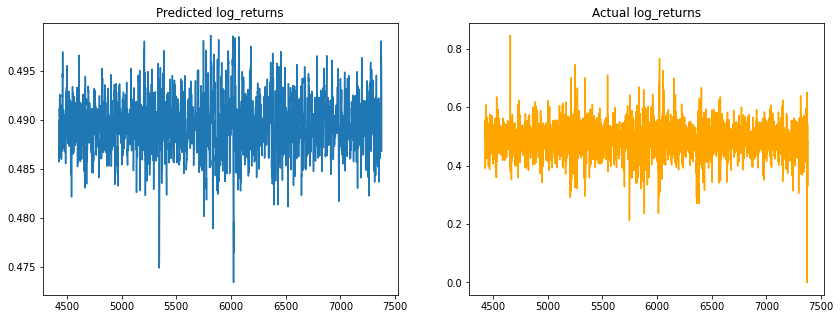

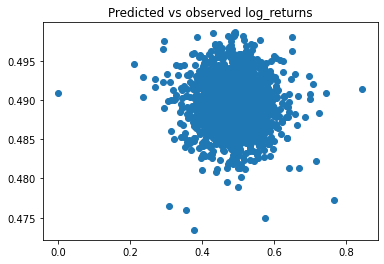

In [90]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted log_returns")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual log_returns")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed log_returns")
plt.show()

* we can see that the predicted values after introducing the tweeter sentiments got more noisy and hence the performance weakened

In [91]:
## Metrics
def score(y_hat, y, metric):
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0048899778672470565, R^2:0.0025588235504829804, MAE:0.047706823278089464
----------------
Out-of-sample scores
MSE:0.0029600063401669487, R^2:-0.006973206442357993, MAE:0.03985502888323508
